In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib notebook

Time to pre-process5.5625


<IPython.core.display.Javascript object>


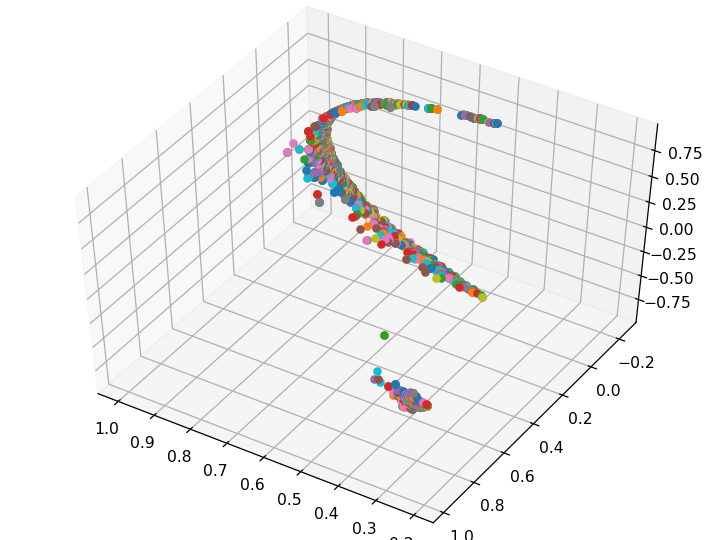

[[ 0.22442804  0.97430197  0.01917629]
 [ 0.22442804  0.97430197  0.01917629]
 [ 0.22442804  0.97430197  0.01917629]
 ...
 [ 0.94412524 -0.18059979 -0.27570139]
 [ 0.77686308 -0.08580487 -0.62379586]
 [ 0.23705722  0.97109545 -0.02788356]]


In [3]:
all_texts=[]
Y = []
start = time.process_time()
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//Dataset-WebACE-Torch")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GWO")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process"+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
random.shuffle(X)
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 140)
plt.show()

In [4]:
max_iter = 100 #Maximum number of iterations
N = 12         #Population size (In the range 5 to 12)
K = 5         #Number of clusters

In [5]:
def population_initialization():
    '''
    Parameters:
    Output:
        N wolves of length K*D where D is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated N times
    '''
    wolves_pack=[]
    for i in range(N):
        wolf=[]
        for j in range(K):
            wolf.append(X[random.randint(0,len(X)-1)])
        wolf=list(itertools.chain(*wolf))
        wolves_pack.append(wolf)
    return wolves_pack

In [6]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [7]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [8]:
def fitness_function(wolf):
    '''
    Input : wolf -> A 1 x d(number of documents) vector containing the initial population
    Output: theta -> Fitness value of each wolf
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
        
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][:,i]
                    t2 = U[k][:,i]
                    diff = abs(t2.shape[0]-t1.shape[0])
                    if t1.shape[0] < t2.shape[0]:
                        t1 = np.append(t1, np.zeros(diff))
                    elif t1.shape[0] > t2.shape[0]:
                        t2 = np.append(t2, np.zeros(diff))
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
    
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    wolf =[]
    for i in range(len(centers)):
        wolf.extend(centers[i])
    fitness_score = theta
    return fitness_score,wolf

In [9]:
def fitness_evaluation(wolves):
    '''
    Input: wolves -> A N x d dimension matrix containing wolves
    Output:fitness-> A N x 1 dimension vector containing fitness values of all wolves
    '''
    fitness = []
    new_wolves=[]
    for i in range(len(wolves)):
        fit,wolf = fitness_function(wolves[i])
        fitness.append(fit)
        new_wolves.append(wolf)
    return fitness,new_wolves

In [10]:
def find_beta(wolves, fitness):
    alpha = max(fitness)
    beta  = -1000
    for i in fitness:
        if beta<i and i!=alpha:
            beta = i
    return wolves[fitness.index(beta)]

In [11]:
def find_gamma(wolves,fitness, beta):
    alpha = max(fitness)
    gamma = -10000
    for i in fitness:
        if gamma<i and i!=alpha and i!=beta:
            gamma = i
    return wolves[fitness.index(gamma)]

In [12]:
def grey_wolf_optimization():
    gen_fitness = []
    start = time.process_time()
    wolves = population_initialization()
    fitness,wolves= fitness_evaluation(wolves)
    alpha  = wolves[fitness.index(max(fitness))] 
    beta   = find_beta(wolves, fitness)
    gamma  = find_gamma(wolves, fitness, fitness[wolves.index(beta)])
    
    a = 2
    
    C1 = 2*np.random.random(size = len(alpha))
    C2 = 2*np.random.random(size = len(beta))
    C3 = 2*np.random.random(size = len(gamma))
    
    A1 = 2*a*np.random.random(size = len(alpha)) - a 
    A2 = 2*a*np.random.random(size = len(beta)) - a
    A3 = 2*a*np.random.random(size = len(gamma)) - a
    
    t = 0
    gen_vs_fitness = []
    stop_gwo = False
    while t<max_iter and not stop_gwo:
        for i in wolves:
            if i!=alpha and i!=beta and i!=gamma:
                D_alpha = np.linalg.norm(np.dot(C1,alpha)-i)
                D_beta  = np.linalg.norm(np.dot(C2,beta)-i)
                D_gamma = np.linalg.norm(np.dot(C3,gamma)-i)

                X1 = alpha - A1*D_alpha
                X2 = beta - A2*D_beta
                X3 = gamma - A3*D_gamma

                i = (X1+X2+X3)/3
        #-----------------------------------------------------
        a = 2 - t*(2/max_iter)
        
        C1 = 2*np.random.random(size = len(alpha))
        C2 = 2*np.random.random(size = len(beta))
        C3 = 2*np.random.random(size = len(gamma))

        A1 = 2*a*np.random.random(size = len(alpha)) - a 
        A2 = 2*a*np.random.random(size = len(beta)) - a
        A3 = 2*a*np.random.random(size = len(gamma)) - a
        
        t = t + 1
        
        fitnes, wolves = fitness_evaluation(wolves)
        temp = []
        temp.append(str(t))
        temp.append(str(max(fitnes)))
        gen_fitness.append(temp)
        print("Generation "+ str(t) + ": "+str(max(fitnes)))
        if t>2 and abs(max(fitnes)-gen_vs_fitness[-1])<0.001 and abs(max(fitnes)-gen_vs_fitness[-2])<0.001:
            stop_gwo=True
            print("Stopping GWO because same results over past 2 generations")
        else:
            gen_vs_fitness.append(max(fitnes))
        alpha  = wolves[fitnes.index(max(fitnes))] 
        beta   = find_beta(wolves, fitnes)
        gamma  = find_gamma(wolves, fitnes, fitnes[wolves.index(beta)])
    
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GWO with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return alpha

In [13]:
def intracluster_distances(wolf):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(wolf):
    intra_distance = intracluster_distances(wolf)
    
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = (b-a)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(wolf))
    return numerator/denominator

In [18]:
def supervised_scores(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(Y_pred)
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def plot(wolf):
    centers=[]
    
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
   #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#dd6622','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation 1: 16.542208824284465
Generation 2: 16.44718052668337
Generation 3: 16.560457153976483
Generation 4: 16.52676038287646
Generation 5: 16.612080325332347
Generation 6: 16.601893230319625
Generation 7: 16.673134456675605
Generation 8: 16.6731344566756
Generation 9: 16.6731344566756
Stopping GWO because same results over past 2 generations
Time taken: 41.84375
DB Index        :0.716599707631453
Silhoutte Index :0.39171253504705583
Calinski-Harabasz Index :12681.620221181693
78
953
2869


<IPython.core.display.Javascript object>


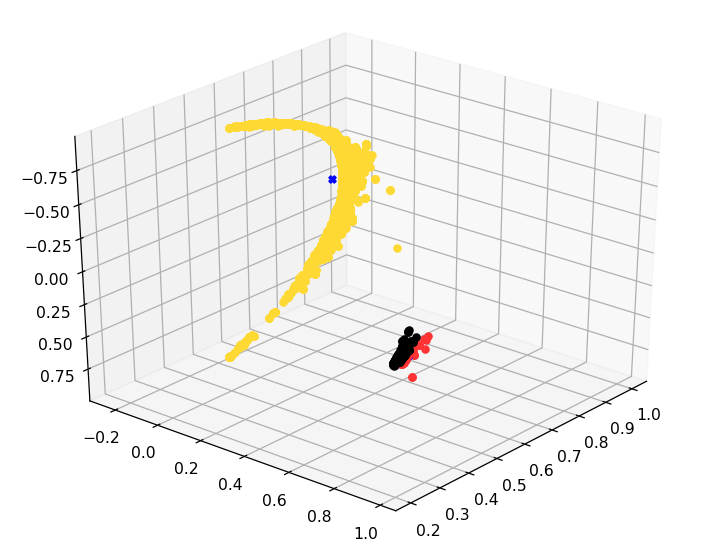

In [24]:
K = 3
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 49.672348277318775
Generation 2: 50.49609994117722
Generation 3: 50.91554491164194
Generation 4: 51.037334138482244
Generation 5: 50.73405491686009
Generation 6: 50.55802501293472
Generation 7: 50.643308624185416
Generation 8: 51.00804269888129
Generation 9: 51.22407304068013
Generation 10: 51.27620459969712
Generation 11: 51.27980221445369
Generation 12: 51.42983306442463
Generation 13: 51.36016968515998
Generation 14: 51.625020985234926
Generation 15: 51.452116958449636
Generation 16: 51.426623468093666
Generation 17: 51.426623468093666
Generation 18: 51.426623468093666
Stopping GWO because same results over past 2 generations
Time taken: 91.796875
DB Index        :0.7764924028047733
Silhoutte Index :0.8715730770384875
Calinski-Harabasz Index :16254.621474953374
73
586
1202
372
1667


<IPython.core.display.Javascript object>


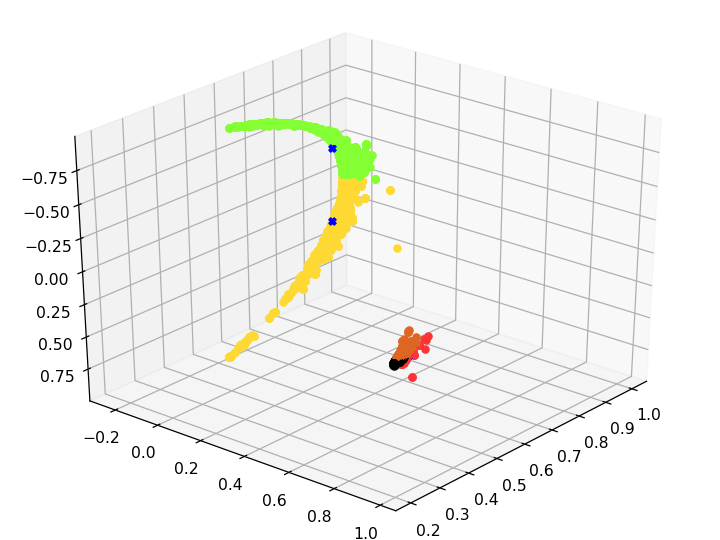

In [25]:
K = 5
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 110.30342069832328
Generation 2: 110.01022988510316
Generation 3: 109.92030773328128
Generation 4: 109.66063072157856
Generation 5: 109.85678819149005
Generation 6: 109.19952990692965
Generation 7: 109.72273761788706
Generation 8: 109.7607137800566
Generation 9: 109.7607137800566
Generation 10: 109.7607137800566
Stopping GWO because same results over past 2 generations
Time taken: 67.671875
DB Index        :0.6959359457898021
Silhoutte Index :0.9175261204587332
Calinski-Harabasz Index :20381.384560891463
30
541
387
878
73
314
1677


<IPython.core.display.Javascript object>


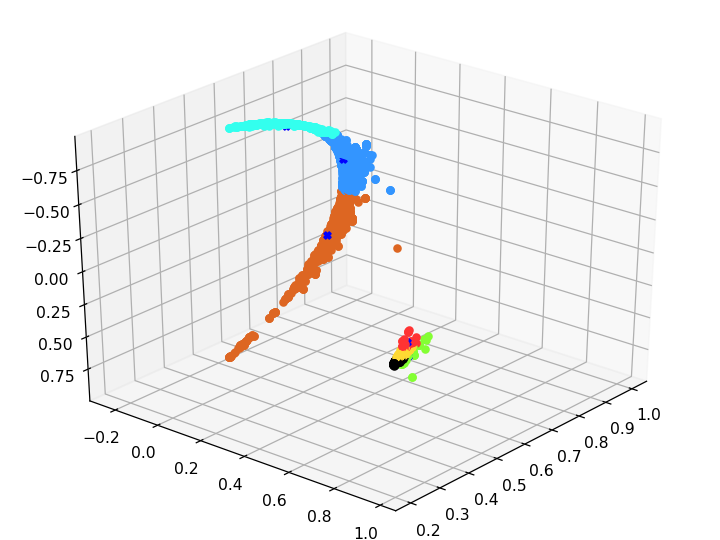

In [29]:
K = 7
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 180.09746813484986
Generation 2: 180.7912351419105
Generation 3: 180.79947433684148
Generation 4: 182.21421968267805
Generation 5: 181.93697569542226
Generation 6: 180.8073193720476
Generation 7: 181.90576602279577
Generation 8: 185.20889983169855
Generation 9: 185.16817858119668
Generation 10: 186.1696457171719


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 11: 181.01023433470073


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 12: 182.43050440610995


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 13: 183.64099572119474


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 14: 184.096158155291


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 15: 184.7998017926054


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 16: 181.70310224650902


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 17: 181.3939804497955


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 18: 182.4363015826175


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 19: 181.97940400131674


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 20: 182.49296877061929


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 21: 181.77127291521379


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 22: 181.40641701312651


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 23: 181.583957082405


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 24: 181.8629550166821


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 25: 181.66726453284778


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 26: 181.74851178486955


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 27: 181.89005337965568


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 28: 182.03750551554361


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 29: 182.03750551554364


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Generation 30: 182.03750551554364
Stopping GWO because same results over past 2 generations
Time taken: 217.6875
DB Index        :0.6514054020723694
Silhoutte Index :0.9736055499817606
Calinski-Harabasz Index :45958.283851530585
993
241
797
669
383
169
73
535
40


<IPython.core.display.Javascript object>


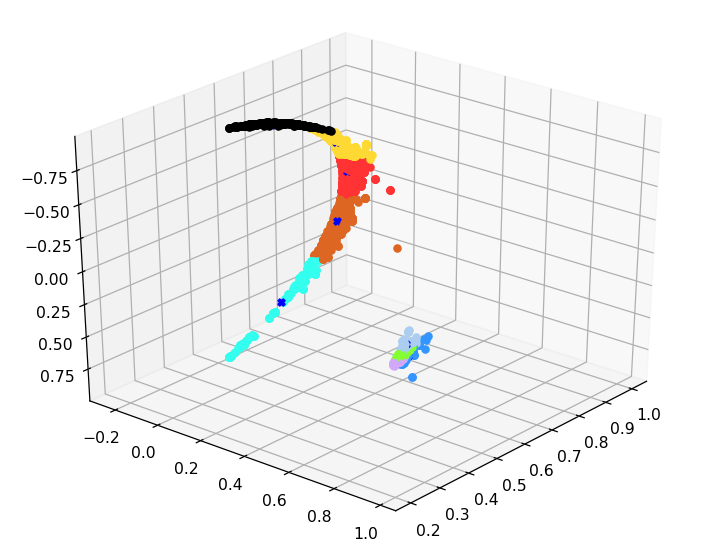

In [28]:
K = 9
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)